# Hannah Zhao - Week 3 DenseNet Model with MIL
## MIL (Multiple Instance Learning) stops you from punishing for “normal‐looking” patches in High-grade cases by moving supervision up to the case level
### Goal: Densenet backbone on h&e, sox, and melan stains with the updated patches, balancing them 
#### overall results:  
#### next step: 

In [22]:
# Standard library imports
import os
import re
import random
import shutil
from datetime import datetime
from collections import OrderedDict

# Data handling and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch and TorchVision libraries for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.models as models
from torchvision import transforms, datasets
from PIL import Image

# Scikit-Learn for evaluation metrics and data splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Imbalanced-learn for oversampling to address class imbalance
from imblearn.over_sampling import RandomOverSampler

from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image
from PIL import Image
from PIL import UnidentifiedImageError
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import ConfusionMatrixDisplay

import os, re, random
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split

In [23]:
# Define local file paths

# Define your Desktop folder based on your OS; this uses the user's home directory.
desktop = os.path.join(os.path.expanduser("~"), "Desktop")

# Path to the filtered patches folder on your Desktop
filtered_patches_dir = os.path.join(desktop, "uni", "STAT 390", "Hannah Zhao", "CMIL_SP2025_Patches_Apr27")

# Path to the CSV file inside Desktop/uni/STAT 390/Hannah Zhao
csv_file_path = os.path.join(desktop, "uni", "STAT 390", "Hannah Zhao", "case_grade_match.csv")

# Directory to store model checkpoints
checkpoint_dir = os.path.join(desktop, "uni", "STAT 390", "Hannah Zhao", "Checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)  # Create the directory if it doesn't exist

# load labels 
labels = pd.read_csv(csv_file_path)

In [24]:
def group_patches_recursive(root_dir):
    case_patches = {}
    for root, _, files in os.walk(root_dir):
        for filename in files:
            match = re.search(r"case_(\d+)", filename)
            if match and filename.endswith(".png"):
                case_num = int(match.group(1))
                if case_num not in case_patches:
                    case_patches[case_num] = []
                case_patches[case_num].append(os.path.join(root, filename))
    return case_patches

patches = group_patches_recursive(filtered_patches_dir)

# Validation / Test transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Training transform (augmented)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# === Load and filter case labels ===
case_nums = list(patches.keys())
dataset = labels.loc[[(x-1) for x in case_nums]]  # Adjust indexing
valid_classes = [1.0, 3.0, 4.0]
filtered_dataset = dataset[dataset['Class'].isin(valid_classes)]

X = filtered_dataset.Case.reset_index(drop=True)
y = filtered_dataset.Class.reset_index(drop=True)
case_to_class = {c: 0 if cl == 1.0 else 1 for c, cl in zip(X, y)}  # Binary class map

# === Stratified split: 60% train, 20% val, 20% test per class ===
cases_by_class = defaultdict(list)
for case_id, label in case_to_class.items():
    cases_by_class[label].append(case_id)

train_cases, val_cases, test_cases = [], [], []
for label, cases in cases_by_class.items():
    train_c, temp_c = train_test_split(cases, test_size=0.4, random_state=42)
    val_c, test_c = train_test_split(temp_c, test_size=0.5, random_state=42)
    train_cases += train_c
    val_cases += val_c
    test_cases += test_c

# === Subset patch dictionary ===
train_patches = {c: patches[c] for c in train_cases if c in patches}
val_patches   = {c: patches[c] for c in val_cases if c in patches}
test_patches  = {c: patches[c] for c in test_cases if c in patches}

# === Optional: filter to just H&E stain ===
def filter_by_stain(d, keyword):
    out, dropped = {}, []
    for c, paths in d.items():
        filtered = [p for p in paths if keyword.lower() in os.path.basename(p).lower()]
        if filtered:
            out[c] = filtered
        else:
            dropped.append(c)
    if dropped:
        print(f"⚠️ Dropped cases with no '{keyword}' patches: {dropped}")
    return out

stain = "h&e"
train_patches = filter_by_stain(train_patches, stain)
val_patches   = filter_by_stain(val_patches, stain)
test_patches  = filter_by_stain(test_patches, stain)

# === Optional: report class distribution ===
def summarize_cases(case_list, label_map):
    labels = [label_map[c] for c in case_list]
    return Counter(labels)

print(f"\n📊 Case counts:")
print(f"Train: {summarize_cases(train_cases, case_to_class)}")
print(f"Val:   {summarize_cases(val_cases, case_to_class)}")
print(f"Test:  {summarize_cases(test_cases, case_to_class)}")


⚠️ Dropped cases with no 'h&e' patches: [58]

📊 Case counts:
Train: Counter({1: 23, 0: 11})
Val:   Counter({1: 8, 0: 4})
Test:  Counter({1: 8, 0: 4})


In [25]:
# === Patch Dataset ===
class PatchLevelDataset(Dataset):
    def __init__(self, case_patches, labels_df, transform=None, balance=True):
        self.data = []
        self.transform = transform
        self.label_map = {1.0: 0, 3.0: 1, 4.0: 1}
        for case_id, patch_paths in case_patches.items():
            raw_label = labels_df.loc[labels_df['Case'] == case_id, 'Class'].item()
            label = self.label_map[raw_label]
            for patch_path in patch_paths:
                self.data.append((patch_path, label))
        if balance:
            counts = Counter([label for _, label in self.data])
            min_count = min(counts.values())
            balanced = {0: [], 1: []}
            for path, label in self.data:
                if len(balanced[label]) < min_count:
                    balanced[label].append((path, label))
            self.data = balanced[0] + balanced[1]

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        path, label = self.data[idx]
        try:
            img = Image.open(path).convert('RGB')
        except Exception as e:
            print(f"⚠️ Skipping corrupted image: {path}")
            # Return a blank image and dummy label — or resample
            return self.__getitem__((idx + 1) % len(self))  # retry with next sample
        if self.transform:
            img = self.transform(img)
        return img, label

# === Model ===
class PatchClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        self.features = base.features
        self.pool = nn.AdaptiveAvgPool2d((2, 2))
        self.classifier = nn.Linear(base.classifier.in_features * 4, 2)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x).view(x.size(0), -1)
        x = self.classifier(x)
        return x
    

# === Training and Eval ===
def train_patch_classifier(model, train_loader, val_loader, criterion, optimizer, device, epochs=5):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"[Epoch {epoch+1}]"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader):.4f}")
        evaluate_patch_classifier(model, val_loader, device, "Validation")

def evaluate_patch_classifier(model, loader, device, title="Test"):
    model.eval()
    all_preds, all_trues = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_trues.extend(labels.numpy())
    print(f"\n=== {title} Classification Report ===")
    print(classification_report(all_trues, all_preds, target_names=['Benign', 'High-grade CMIL']))
    cm = confusion_matrix(all_trues, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'High-grade CMIL'])
    disp.plot(cmap="Blues", values_format='d')
    plt.title(f"{title} Confusion Matrix")
    plt.show()


In [26]:
# === Run training ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
patch_model = PatchClassifier()
patch_optimizer = torch.optim.Adam(patch_model.parameters(), lr=1e-4)
patch_criterion = nn.CrossEntropyLoss()

train_ds = PatchLevelDataset(train_patches, labels, transform=train_transform)
val_ds = PatchLevelDataset(val_patches, labels, transform = transform, balance=True)
test_ds = PatchLevelDataset(test_patches, labels, transform=transform, balance=False)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

In [27]:
def summarize_split(ds, name=""):
    counts = Counter([label for _, label in ds])
    print(f"📊 {name} patch counts: {dict(counts)}")

summarize_split(train_ds, "Train")
summarize_split(val_ds, "Validation")
summarize_split(test_ds, "Test")

📊 Train patch counts: {0: 3486, 1: 3486}
📊 Validation patch counts: {0: 829, 1: 829}
📊 Test patch counts: {1: 3250, 0: 1831}


[Epoch 1]: 100%|██████████| 218/218 [1:01:43<00:00, 16.99s/it]


Epoch 1, Training Loss: 0.3978

=== Validation Classification Report ===
                 precision    recall  f1-score   support

         Benign       0.63      0.74      0.68       829
High-grade CMIL       0.69      0.57      0.63       829

       accuracy                           0.66      1658
      macro avg       0.66      0.66      0.65      1658
   weighted avg       0.66      0.66      0.65      1658



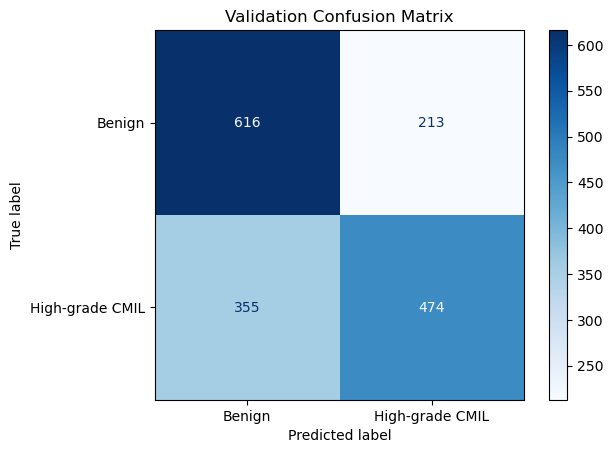

[Epoch 2]: 100%|██████████| 218/218 [59:09<00:00, 16.28s/it]


Epoch 2, Training Loss: 0.2918

=== Validation Classification Report ===
                 precision    recall  f1-score   support

         Benign       0.77      0.54      0.63       829
High-grade CMIL       0.64      0.84      0.73       829

       accuracy                           0.69      1658
      macro avg       0.71      0.69      0.68      1658
   weighted avg       0.71      0.69      0.68      1658



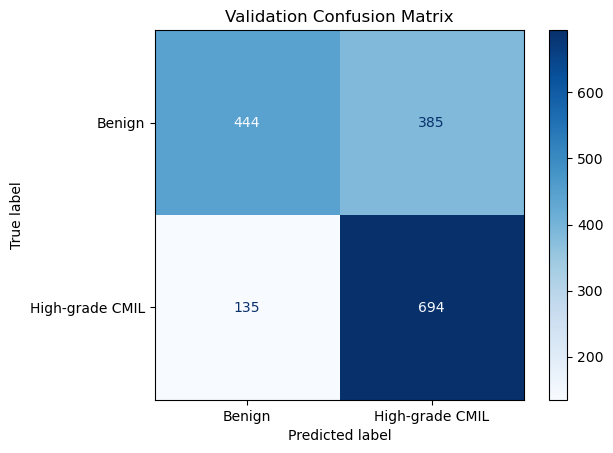

[Epoch 3]: 100%|██████████| 218/218 [58:38<00:00, 16.14s/it] 


Epoch 3, Training Loss: 0.2427

=== Validation Classification Report ===
                 precision    recall  f1-score   support

         Benign       0.76      0.75      0.75       829
High-grade CMIL       0.75      0.76      0.75       829

       accuracy                           0.75      1658
      macro avg       0.75      0.75      0.75      1658
   weighted avg       0.75      0.75      0.75      1658



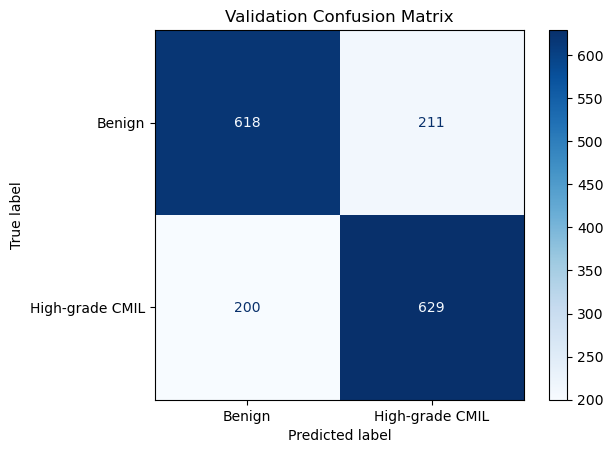

[Epoch 4]: 100%|██████████| 218/218 [1:00:39<00:00, 16.69s/it]


Epoch 4, Training Loss: 0.2154

=== Validation Classification Report ===
                 precision    recall  f1-score   support

         Benign       0.80      0.74      0.77       829
High-grade CMIL       0.76      0.82      0.79       829

       accuracy                           0.78      1658
      macro avg       0.78      0.78      0.78      1658
   weighted avg       0.78      0.78      0.78      1658



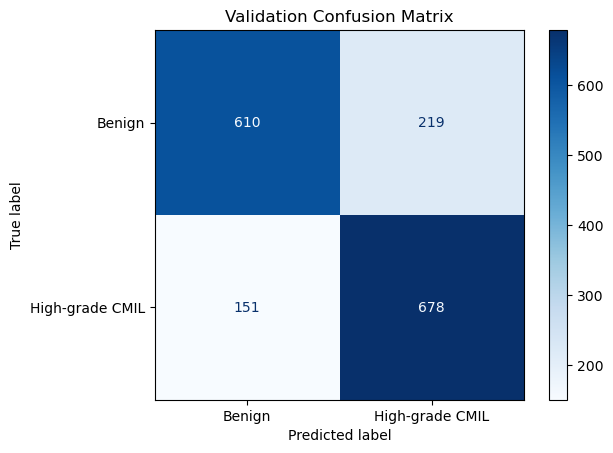

[Epoch 5]: 100%|██████████| 218/218 [1:00:12<00:00, 16.57s/it]


Epoch 5, Training Loss: 0.2090

=== Validation Classification Report ===
                 precision    recall  f1-score   support

         Benign       0.79      0.60      0.68       829
High-grade CMIL       0.68      0.84      0.75       829

       accuracy                           0.72      1658
      macro avg       0.73      0.72      0.72      1658
   weighted avg       0.73      0.72      0.72      1658



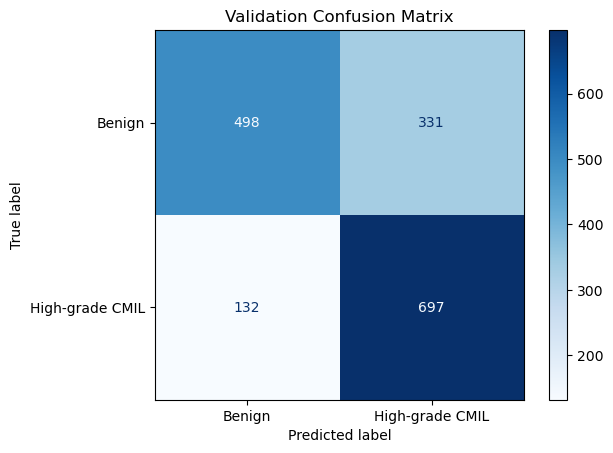

In [28]:
train_patch_classifier(patch_model, train_loader, val_loader, patch_criterion, patch_optimizer, device, epochs=5)


=== Test Classification Report ===
                 precision    recall  f1-score   support

         Benign       0.51      0.61      0.56      1831
High-grade CMIL       0.75      0.68      0.71      3250

       accuracy                           0.65      5081
      macro avg       0.63      0.64      0.63      5081
   weighted avg       0.67      0.65      0.66      5081



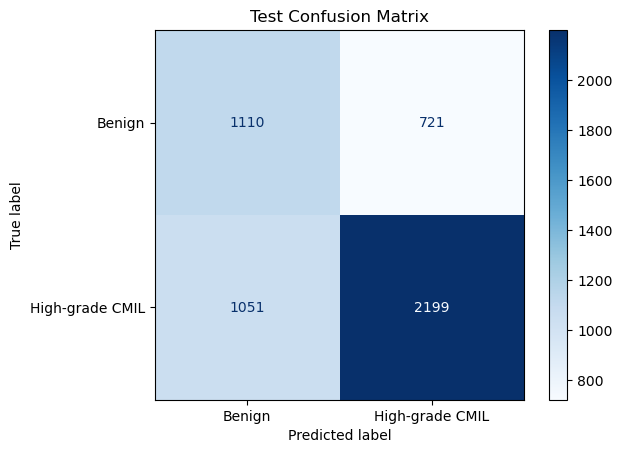

In [29]:
evaluate_patch_classifier(patch_model, test_loader, device, "Test")

In [30]:
# === Save patch model checkpoint ===
checkpoint_path = os.path.join(checkpoint_dir, "patch_classifier_3.pth")
torch.save(patch_model.state_dict(), checkpoint_path)
print(f"✅ Patch model saved to {checkpoint_path}")

✅ Patch model saved to /Users/hannahzhao/Desktop/uni/STAT 390/Hannah Zhao/Checkpoints/patch_classifier_3.pth
